# Preprocessing

In [ ]:
!pip install datasets
# !pip install mltu==0.1.3
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from datasets import load_dataset
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import tensorflow as tf

from keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint



In [ ]:
dataset = load_dataset("priyank-m/MJSynth_text_recognition", split="train[:20000]")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7224600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/891924 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/802733 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/priyank-m___parquet/priyank-m--MJSynth_text_recognition-fd327f58595eddf5/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


In [ ]:
# this = [len(a) for a in dataset['label']]
import string

char_list = string.ascii_letters+string.digits
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [ ]:
dataset = dataset.train_test_split(test_size=0.4)

In [ ]:
DataTrain, DataVal = dataset['train'], dataset['test']

In [ ]:
# type(DataTrain['label'][1])

In [ ]:
# Max Length
max_vocab_train = [len(a) for a in DataTrain['label']]
max_vocab_val = [len(a) for a in DataVal['label']]

max_vocab_train = np.array(max_vocab_train)
max_vocab_val = np.array(max_vocab_val)
# Encode to int
encode_train_text = [encode_to_labels(a) for a in DataTrain['label']]
encode_val_text = [encode_to_labels(a) for a in DataVal['label']]

In [ ]:
train_input_length = [ 31 for n in range(len(DataTrain['label']))]
(train_input_length) = np.array(train_input_length)

val_input_length = [ 31 for n in range(len(DataVal['label']))]
(val_input_length) = np.array(val_input_length)

In [ ]:
max_label_len = max(max(max_vocab_train), max(max_vocab_val))
max_label_len

23

In [ ]:
max_label_len

23

In [ ]:
train_padded_txt = pad_sequences(encode_train_text,
                                #  maxlen=max(max_vocab_train),
                                 maxlen= (max_label_len),
                                 padding='post',
                                 value = len(char_list))
train_padded_txt = np.array(train_padded_txt)

In [ ]:
val_padded_txt = pad_sequences(encode_val_text,
                                #  maxlen=max(max_vocab_val),
                                 maxlen= (max_label_len),
                                 padding='post',
                                 value = len(char_list))
val_padded_txt = np.array(val_padded_txt)

In [ ]:
val_padded_txt[0]

array([44, 15, 17,  8, 19, 25,  4, 17, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62], dtype=int32)

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [image.convert("RGB").resize((128,32)) for image in examples["image"]]
    return examples

In [ ]:
ImgTrain = DataTrain.map(transforms, remove_columns=["image"], batched=True)
# ImgTrain[0]
Img_Train = (ImgTrain['pixel_values'])


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [ ]:
ImgVal = DataVal.map(transforms, remove_columns=["image"], batched=True)
Img_Val = (ImgVal['pixel_values'])


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

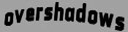

In [ ]:
Img_Train[0]

In [ ]:
thisA = [np.array(n) for n in Img_Train]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
thisB = [np.array(n) for n in Img_Val]

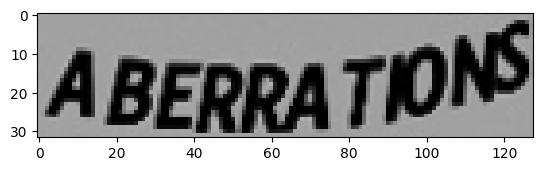

In [ ]:
plt.imshow(thisB[1])

In [ ]:
## use np array to converting PIL image mode to numpy
def transforms2(examples):
    examples["pixel_values"] = [image.convert('RGB').resize((128,32)) for image in examples["image"]]
    return examples

Imgtest = DataVal.map(transforms2, remove_columns=["image"], batched=True)
Imgtest = (Imgtest['pixel_values'])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:

pil_image = Imgtest[0]
opencvImage = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
opencvImage.shape

(32, 128, 3)

In [ ]:
# graytest = cv2.cvtColor(opencvImage, cv2.COLOR_BGR2GRAY)

In [ ]:
# graytest = tf.image.rgb_to_grayscale(opencvImage)
# graytest/255

In [ ]:
# ## floating img
# this_Train = [n/255 for n in thisA]
# this_Val = [n/255 for n in thisB]

In [ ]:
Train_Image = [(tf.image.rgb_to_grayscale(n))/255 for n in (thisA)]
Val_Image = [(tf.image.rgb_to_grayscale(n))/255 for n in (thisB)]


In [ ]:
Train_Image = np.asarray(Train_Image)
Val_Image = np.asarray(Val_Image)

# Model

In [ ]:
from datetime import datetime
char_list
model_path = os.path.join("/content/SaveModel", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))

In [ ]:
# # Tutorials/01_image_to_word/model.py
# from keras import layers
# from keras.models import Model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# from mltu.dataProvider import DataProvider
# from mltu.preprocessors import ImageReader
# # from mltu.annotations.images import CVImage
# from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
# from mltu.losses import CTCloss
# from mltu.callbacks import Model2onnx, TrainLogger
# from mltu.metrics import CWERMetric

# from mltu.model_utils import residual_block

# def train_model(input_dim, output_dim, activation='leaky_relu', dropout=0.2):

#     inputs = layers.Input(shape=input_dim, name="input")

#     input = layers.Lambda(lambda x: x / 255)(inputs)

#     x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

#     x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
#     x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

#     x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
#     x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

#     x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)
#     x7 = residual_block(x6, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

#     squeezed = layers.Reshape((x7.shape[-3] * x7.shape[-2], x7.shape[-1]))(x7)

#     blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(squeezed)

#     output = layers.Dense(output_dim + 1, activation='softmax', name="output")(blstm)

#     model = Model(inputs=inputs, outputs=output)
#     return model

In [ ]:
# import tensorflow as tf

# class CTCloss(tf.keras.losses.Loss):
#     """ CTCLoss objec for training the model"""
#     def __init__(self, name: str = 'CTCloss') -> None:
#         super(CTCloss, self).__init__()
#         self.name = name
#         self.loss_fn = tf.keras.backend.ctc_batch_cost

#     def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> tf.Tensor:
#         """ Compute the training batch CTC loss value"""
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)

#         return loss

In [ ]:
# # Tutorials/01_image_to_word/train.py
# model = train_model(
#     input_dim = (32, 128, 3),
#     output_dim = len(char_list),
# )
# # Compile the model and print summary
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04),
#     loss=CTCloss(),
#     metrics=[CWERMetric()],
#     run_eagerly=False
# )

# # Define callbacks
# earlystopper = EarlyStopping(monitor='val_CER', patience=10, verbose=1)
# checkpoint = ModelCheckpoint(f"{model_path}/model.h5", monitor='val_CER', verbose=1, save_best_only=True, mode='min')
# trainLogger = TrainLogger(model_path)
# tb_callback = TensorBoard(f'{model_path}/logs', update_freq=1)
# reduceLROnPlat = ReduceLROnPlateau(monitor='val_CER', factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode='auto')
# model2onnx = Model2onnx(f"{model_path}/model.h5")

# # Train the model
# model.fit(
#     [thisA],[train_padded_txt],
#     validation_data = ([val_padded_txt, thisB]) ,
#     epochs=100,
#     callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
#     workers=20
# )

# Model 2

In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', run_eagerly=True )

filepath="best_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 64)  640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 64, 128)  73856       ['max_pooling2d[0][0]']      

In [ ]:
# labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
# input_length = Input(name='input_length', shape=[1], dtype='int64')
# label_length = Input(name='label_length', shape=[1], dtype='int64')


# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args

#     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# #model to be used at training time
# model2 = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# filepath="best_model.h5"
# checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
# callbacks_list = [checkpoint]


In [ ]:
## looking into configuration Validation
nval_input = np.expand_dims(np.array(val_input_length), axis = 1)
nval_label = np.expand_dims(np.array(max_vocab_val), axis = 1)
Val_Image.shape, val_padded_txt.shape, nval_input.shape, nval_label.shape

((8000, 32, 128, 1), (8000, 23), (8000, 1), (8000, 1))

In [ ]:
## looking into configuration Training
ntrain_input = np.expand_dims(np.array(train_input_length), axis = 1)
ntrain_label = np.expand_dims(np.array(max_vocab_train), axis = 1)
Train_Image.shape, train_padded_txt.shape, ntrain_input.shape, ntrain_label.shape

((12000, 32, 128, 1), (12000, 23), (12000, 1), (12000, 1))

In [ ]:
# model.fit(x=[Train_Image, train_padded_txt, ntrain_input, ntrain_label],
#           y=np.zeros(len(Train_Image)),
#           batch_size =256, epochs = 500,
#           validation_data = ([Val_Image, val_padded_txt, nval_input, nval_label],
#                              [np.zeros(len(Val_Image))]),
#           verbose = 1, callbacks = callbacks_list)

In [ ]:
#  Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>", '(<class \'list\'> containing values of types {"<class \'numpy.ndarray\'>"})', "<class 'int'>"}), <class 'numpy.ndarray'>

In [ ]:
# print(Train_Image, train_padded_txt.shape,  np.array(max_vocab_train).shape)

In [ ]:
# max_vocab_train

In [ ]:
# dumm.reshape(32, 1)

In [ ]:
history = model.fit(x=[Train_Image, train_padded_txt, ntrain_input, ntrain_label],
                    y=np.zeros(len(Train_Image)),
                    batch_size =256, epochs = 10,
                    validation_data = ([Val_Image, val_padded_txt, nval_input, nval_label],
                             [np.zeros(len(Val_Image))]),
                    verbose = 1, callbacks = callbacks_list)

print(history.history.keys())

plt.figure(1)

# summarize history for accuracy

# plt.subplot(211)
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/10
43/47 [==========================>...] - ETA: 2:45 - loss: 34.9314

In [ ]:
print(history.history.keys())

plt.figure(1)

# summarize history for accuracy

# plt.subplot(211)
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

# # summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TESTING

In [ ]:
!unzip test.zip

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
def get_image_resize(img):
    # for i in f_name:
    # img = cv2.imread(i,0)
    h,w= img.shape
    width = (128,32)
    img_resize = cv2.resize(img,(128,32))
    # print("resize image function",img.shape,img_resize.shape)
    return img_resize



def preprocess(img_):
    image_list=[]
    for f_name in img_:
        img = cv2.cvtColor(cv2.imread(f_name), cv2.COLOR_BGR2GRAY)
        # convert each image of shape (32, 128, 1)
        w, h = img.shape
        if h > 128 or w > 32:
            img = get_image_resize(img)
            w, h = img.shape
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))

        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)

        img = np.expand_dims(img , axis = 2)
        img = img/255.
        image_list.append(img)
    return image_list

img = glob.glob("content/test/*")
img_list = preprocess(img)
# print(img_list)
valid_img = np.array(img_list)
# print(img)
# load the saved best model weights
model.load_weights('/content/best_model.h5')

# predict outputs on validation images
# print(valid_img[0].shape)
prediction = model.predict(valid_img)

out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=False)[0][0])
# print(out)
# see the results
i = 0
for x,img_name in zip(out,img):
    # print(x)
    img = cv2.imread(img_name)
    plt.imshow(img)
    plt.show()
    # print("original_text =  ", img_name.split("/")[-1])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    print('\n')
    i+=1